In [55]:
import re
import pickle
import string
import gensim
import pandas            as pd
import matplotlib.pyplot as plt

from nltk                            import word_tokenize
from nltk.corpus                     import stopwords
from nltk.tokenize                   import TweetTokenizer
from nltk.stem.porter                import PorterStemmer
from wordcloud                       import WordCloud
from collections                     import Counter
from gensim.models                   import Word2Vec
from sklearn.manifold                import TSNE
from IPython.core.display            import HTML
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection         import train_test_split
from sklearn                         import svm
from sklearn.metrics                 import f1_score

In [21]:
location = './twitter_data/train2017.tsv'
df = pd.read_csv(location , sep = "\t" , header = None)

In [65]:
ndf = df.head(10) #takes the first x entries

dl = ndf.values.tolist()

# dl = df.values.tolist()

emotions    = []
positives   = []
negatives   = []
neutrals    = []
tokens      = []
fusedTokens = []
tknzr       = TweetTokenizer(preserve_case = False, 
                             strip_handles = True, 
                             reduce_len    = True)
for item in dl:
    print("\nITEM = ",item)
    tweet = item[3]
    emotions.append(item[2])
#     if item[2] == "positive":
#         emotions.append(1)
#     elif item[2] == "negative":
#         emotions.append(-1)
#     elif item[2] == "neutral":
#         emotions.append(0)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*' , '' , tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+' , '' , tweet)
 
    # remove hyperlinks
#     tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r"http\S+", "", tweet)
    
    # remove hashtags, removing the hash (#) sign only from the word
    tweet = re.sub(r'#' , '' , tweet)
    
    temp = tknzr.tokenize(tweet)
    
    print("TEMP 1 = ",temp)
    
#     temp = [w.lower() for w in temp] #convert to lower case
    
    stop_words = stopwords.words('english')    #sets stop words
    newStopWords = ["i'm" , "he's" , "she's" , "it's" , "we're" , "you're" , "they're" , "via"]
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    
    temp = [w for w in temp if not w in stop_words]  #removes stop words
    print("TEMP 2 = ",temp)

    table = str.maketrans('', '', string.punctuation) #remove punctuation
    temp = [w.translate(table) for w in temp]
    print("TEMP 3 = ",temp)

    temp = [word for word in temp if word.isalpha()] #remove remaining tokens that are not alphabetic
    print("TEMP 4 = ",temp)

#     porter = PorterStemmer() #stemming (not that useful)
#     temp = [porter.stem(word) for word in temp]

    if item[2] == "positive":  #need to give the words positive and negative weight so that the most common words in positive posts is not "tomorrow"
        positives.extend(temp)
    elif item[2] == "negative":
        negatives.extend(temp)
    elif item[2] == "neutral":
        neutrals.extend(temp)
        
    fusedTokens.extend(temp)
    tokens.append(temp)
    
print("\n\033[1;33mPrinting Tokens\033[0m")
for i,tok in enumerate(tokens):
    print("\033[1;34m->\033[0m",tok)
print("\n\033[1;33mPrinting Fuzed Tokens\033[0m")
print(fusedTokens)


ITEM =  [264183816548130816, '15140428', 'positive', "Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)"]
TEMP 1 =  ['gas', 'by', 'my', 'house', 'hit', '.', '39', '!', '!', '!', "i'm", 'going', 'to', 'chapel', 'hill', 'on', 'sat', '.', ':)']
TEMP 2 =  ['gas', 'house', 'hit', '.', '39', '!', '!', '!', 'going', 'chapel', 'hill', 'sat', '.', ':)']
TEMP 3 =  ['gas', 'house', 'hit', '', '39', '', '', '', 'going', 'chapel', 'hill', 'sat', '', '']
TEMP 4 =  ['gas', 'house', 'hit', 'going', 'chapel', 'hill', 'sat']

ITEM =  [263405084770172928, '591166521', 'negative', 'Theo Walcott is still shit, watch Rafa and Johnny deal with him on Saturday.']
TEMP 1 =  ['theo', 'walcott', 'is', 'still', 'shit', ',', 'watch', 'rafa', 'and', 'johnny', 'deal', 'with', 'him', 'on', 'saturday', '.']
TEMP 2 =  ['theo', 'walcott', 'still', 'shit', ',', 'watch', 'rafa', 'johnny', 'deal', 'saturday', '.']
TEMP 3 =  ['theo', 'walcott', 'still', 'shit', '', 'watch', 'rafa', 'johnny', 'deal', 'saturd

In [23]:
count = Counter(fusedTokens)
print("\033[1;33mGenerally most common words:\033[0m\n" , count.most_common(10))

count = Counter(positives)
print("\033[1;33m\nMost common words found in positive posts:\033[0m\n" , count.most_common(10))

count = Counter(negatives)
print("\033[1;33m\nMost common words found in negative posts:\033[0m\n" , count.most_common(10))

count = Counter(neutrals)
print("\033[1;33m\nMost common words found in neutral posts:\033[0m\n" , count.most_common(10))

Generally most common words:
 [('sat', 2), ('deal', 2), ('cant', 2), ('february', 2), ('talking', 2), ('may', 2), ('end', 2), ('college', 2), ('superbowl', 2), ('dallas', 2)]

Most common words found in positive posts:
 [('gas', 1), ('house', 1), ('hit', 1), ('going', 1), ('chapel', 1), ('hill', 1), ('sat', 1), ('j', 1), ('davlar', 1), ('main', 1)]

Most common words found in negative posts:
 [('deal', 2), ('cant', 2), ('talking', 2), ('may', 2), ('college', 2), ('superbowl', 2), ('dallas', 2), ('theo', 1), ('walcott', 1), ('still', 1)]

Most common words found in neutral posts:
 [('tehran', 1), ('mon', 1), ('amour', 1), ('obama', 1), ('tried', 1), ('establish', 1), ('ties', 1), ('mullahs', 1), ('sat', 1), ('whole', 1)]


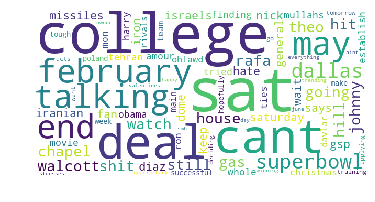

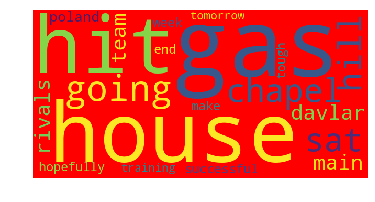

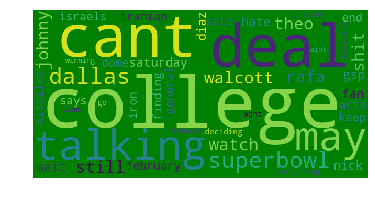

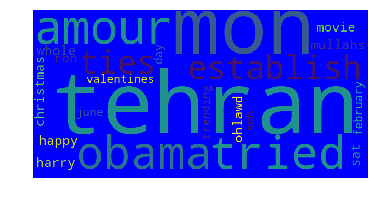

In [24]:
final = ""
for word in fusedTokens:
    final += " " + word
    
wc = WordCloud(background_color = "white", width = 640, height = 320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

# ----------------------------------------------------------#

final = ""
for word in positives:
    final += " " + word
    
wc = WordCloud(background_color = "red", width = 640, height = 320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

# ----------------------------------------------------------#

final = ""
for word in negatives:
    final += " " + word
    
wc = WordCloud(background_color = "green", width = 640, height = 320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

# ----------------------------------------------------------#

final = ""
for word in neutrals:
    final += " " + word
    
wc = WordCloud(background_color = "blue", width = 640, height = 320).generate(final)

plt.imshow(wc)
plt.axis("off")
plt.show()

Generally we can see that words like "love" appear in positive posts as expected , whereas "positive" words like "like" appear in negative posts . Also there are many neutral words like "tomorrow" that have the same distribution in both positive and negative posts.

In [25]:
newTokens = []
for item in tokens:
    final = ""
    for word in item:
        final += " " + word
    print(final)
    newTokens.append(final)
    
# bow_vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=100, stop_words='english')
bow_vectorizer = CountVectorizer(max_features=100) 
bow_xtrain = bow_vectorizer.fit_transform(newTokens)  #TWEETS : a list with the actual tweets 
# print(bow_vectorizer.get_feature_names())
# print(bow_xtrain.toarray())

# The output is a numpy array of features. The dimensionality of this array 
# depends on the number of TWEETS (shape should be number_of_tweets ∙ vocabulary_size) 
print(bow_xtrain.shape)

# filename = "bow.pkl"
outfile = open("bow.pkl" , "wb")
pickle.dump(bow_xtrain , outfile)
outfile.close()

 gas house hit going chapel hill sat
 theo walcott still shit watch rafa johnny deal saturday
 gsp fan hate nick diaz cant wait february
 iranian general says israels iron dome cant deal missiles keep talking like may end finding
 tehran mon amour obama tried establish ties mullahs
 sat whole movie harry ron christmas ohlawd
 j davlar main rivals team poland hopefully make successful end tough week training tomorrow
 talking acts sats deciding want go college applying colleges everything college stresses
 happy valentines day trending february june smh
 may superbowl dallas dallas aint winning superbowl quarterback owner
(10, 85)


In [26]:
# print(bow_vectorizer.get_feature_names())

# for box in bow_xtrain.toarray():
#     print(box)

In [27]:
# tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000, stop_words='english') 
tfidf_vectorizer = TfidfVectorizer(max_features=100) 
tfidf = tfidf_vectorizer.fit_transform(newTokens)
print(tfidf.shape) #the output is a numpy array of features


# filename = "tfidf.pkl"
outfile = open("tfidf.pkl" , "wb")
pickle.dump(tfidf , outfile)
outfile.close()

(10, 85)


In [28]:
# tokenized_tweet = tweets.apply(lambda x: x.split()) # tokenizing 

featuresSize = 10

model_w2v = gensim.models.Word2Vec(tokens,
                                   size      = 10, # desired no. of features/independent variables
                                   window    = 5,  # context window size
                                   min_count = 2,
                                   sg        = 1,  # 1 for skip-gram model
                                   hs        = 0,
                                   negative  = 10, # for negative sampling
                                   workers   = 2,  # no.of cores
                                   seed      = 34) 

model_w2v.train(tokens, total_examples = len(tokens), epochs = 20)


In [29]:
# model_w2v.wv.most_similar(positive="college")
model_w2v.wv.__getitem__("college")

array([-0.03028435, -0.03056458, -0.04742509, -0.04869462, -0.04395926,
       -0.0258976 ,  0.03071398,  0.00198146, -0.0335049 , -0.01921034],
      dtype=float32)

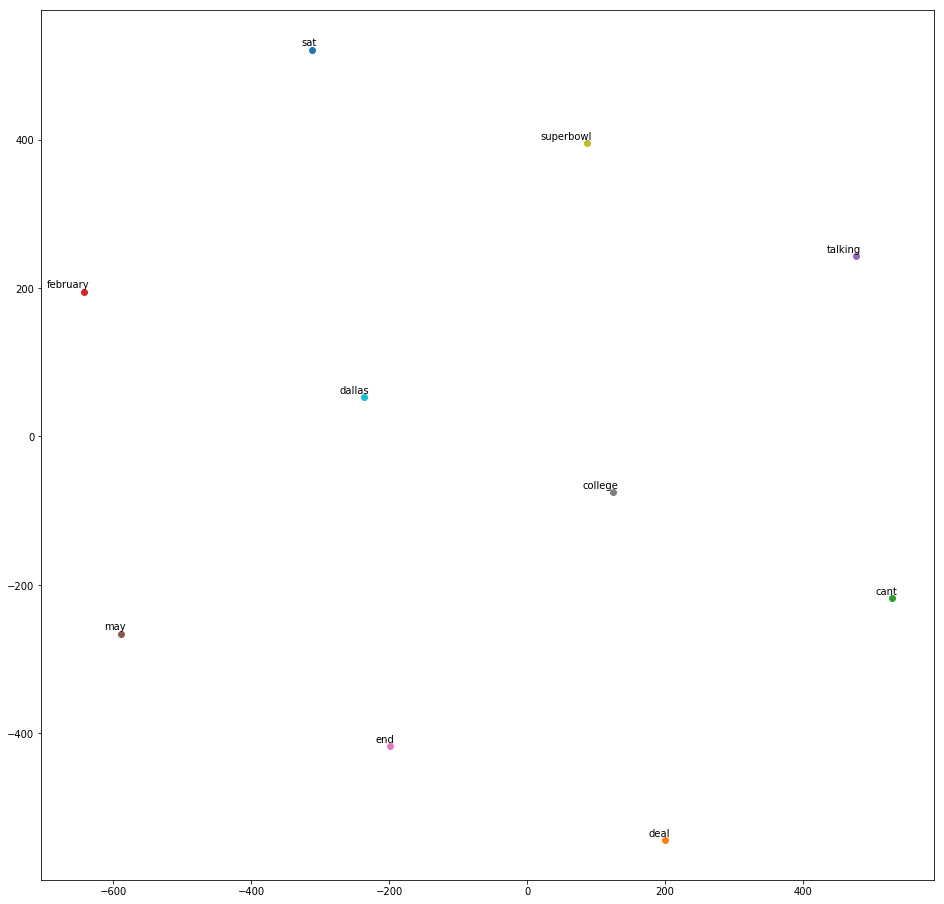

In [30]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    for word in model.wv.vocab:
        tokens.append(model.wv.__getitem__(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity = 40, n_components = 2, init = 'pca', n_iter = 2500, random_state = 23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize = (16,16)) 
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy = (x[i], y[i]), xytext = (5,2), textcoords = 'offset points', ha = 'right', va = 'bottom')
        
    plt.show()

tsne_plot(model_w2v)

In [31]:
dictNum  = 1
allDicts = []

dictLocation = "./lexica/generic/generic.txt"
file = open(dictLocation, "r")
genericDict = []
for line in file:
    temp  = []
    count = 1
    for word in line.split():
        if count == 1:
            temp.append(word)
        else:
            temp.append(float(word))
        count += 1
    genericDict.extend([temp])
    
allDicts.extend([genericDict])

In [32]:
# dictNum += 1

# dictLocation = "./lexica/emotweet/valence_tweet.txt"
# file = open(dictLocation, "r")
# dic = []
# for line in file:
#     temp = []
#     count = 1
#     for word in line.split():
#         if count == 1:
#             temp.append(word)
#         else:
#             temp.append(float(word))
#         count += 1
#     dic.extend([temp])
    
# allDicts.extend([dic])

In [83]:
word_vectors = model_w2v.wv
allTweetFeatsList = []

for sentence in tokens:
    
    tweetFeatures = []
    
    for i in range(0,featuresSize):
        value     = 0
        wordCount = 0
        
        for word in sentence:
            if word in word_vectors.vocab:
                wordCount += 1
                value     += word_vectors[word][i]
                
        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)
    
    for dic in allDicts:
        wordCount = 0
        value     = 0

        for word in sentence:
            for token in dic:
                if word == token[0]:
                    wordCount += 1
                    value     += token[1]

        if wordCount != 0:
            tweetFeatures.append(value / wordCount)
        else:
            tweetFeatures.append(0)

        print(tweetFeatures , "\n")
    
            
    allTweetFeatsList.extend([tweetFeatures])

print(allTweetFeatsList)

# filename = "wordEmbs.pkl"
outfile = open("wordEmbs.pkl" , "wb")
pickle.dump(allTweetFeatsList , outfile)
outfile.close()

[-0.015375356189906597, 0.009968051686882973, 0.03581678867340088, -0.007886035367846489, -0.04052518680691719, -0.028497599065303802, 0.049208104610443115, -0.044669218361377716, 0.04860471189022064, -0.04534119367599487, 0.10738428571428571] 

[-0.041375987231731415, -0.043756261467933655, -0.030355092138051987, 0.025034938007593155, 0.024361565709114075, 0.03922559693455696, -0.04349128156900406, -0.03163343667984009, -0.014368821866810322, 0.0450507216155529, 0.13774633333333336] 

[-0.007258316851221025, -0.03572284057736397, 0.002520577050745487, 0.027923027984797955, 0.024548442102968693, -0.006063720211386681, 0.012578967958688736, -0.02656846074387431, -0.01566140481736511, -0.032017771154642105, 0.079153] 

[-0.019989417772740124, -5.633942782878875e-06, -0.01844455935060978, 0.012261559441685676, -0.0021998034324496986, 0.023897363059222698, -0.027063686470501124, -0.02423023097217083, -0.020549384644255042, 0.024128707498311995, 0.03389825] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [84]:
infile = open("bow.pkl" , "rb")
bow_xtrain = pickle.load(infile)
infile.close()

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(bow_xtrain, emotions, random_state=42, test_size=0.2) #input for this method is any array of features

In [85]:

svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(xtrain_bow, ytrain) # xtrain_bow:bag of words features for train data, ytrain: train data labels

probPrediction = svc.predict_proba(xvalid_bow) #predict on the validation set
prediction_int = svc.predict(xvalid_bow)
prediction_int = prediction_int.tolist()

f1_score(yvalid, prediction_int , average="micro") #evaluate on the validation set



0.5

In [86]:
infile = open("tfidf.pkl" , "rb")
tfidf = pickle.load(infile)
infile.close()

xtrain, xvalid, ytrain, yvalid = train_test_split(tfidf , emotions, random_state=42, test_size=0.2) #input for this method is any array of features

In [87]:
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(xtrain, ytrain) # xtrain:tfidf features for train data, ytrain: train data labels

probPrediction = svc.predict_proba(xvalid) #predict on the validation set
prediction_int = svc.predict(xvalid)
prediction_int = prediction_int.tolist()

f1_score(yvalid, prediction_int , average="micro") #evaluate on the validation set

0.5

In [89]:
infile = open("wordEmbs.pkl" , "rb")
allTweetFeatsList = pickle.load(infile)
infile.close()

xtrain, xvalid, ytrain, yvalid = train_test_split(allTweetFeatsList , emotions, random_state=42, test_size=0.2) #input for this method is any array of features

In [74]:
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(xtrain, ytrain) # xtrain:word2vec features for train data, ytrain: train data labels

probPrediction = svc.predict_proba(xvalid) #predict on the validation set
prediction_int = svc.predict(xvalid)
prediction_int = prediction_int.tolist()

f1_score(yvalid, prediction_int , average="micro") #evaluate on the validation set

0.5